# Loire: catchment 3184

***Table 1**. Reservoir ID in the Global Dam Watch (GDW), Global Reservoir and Dam (GRanD) database and EFAS.*

| GDW_ID | GRanD_ID | EFAS_ID |
| ------ | -------- | ------- |
| 3823 | 3375 | - |

***Figure 1**. Scheme of the catchment including reservoirs (pink triangle) and gauging stations used for calibration (circles).*

<img src="./images/3184.jpg" alt="Catchment scheme" width="800"/>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

In [2]:
from reservoirs_lshm.calibration import read_results
from reservoirs_lshm.calibration.camaflood_calibrator import CamafloodCalibrator
from reservoirs_lshm.models import get_model
from reservoirs_lshm.models import Camaflood
from reservoirs_lshm.utils.metrics import KGEmod

In [3]:
import spotpy

## Configuration

In [4]:
path_efas = Path('Z:/nahaUsers/casadje/EFASv6/reservoirs/')
path_catchment = path_efas / 'tests' / 'Loire'
path_obs = path_catchment / 'HYDRO' / 'timeseries'

### Reservoirs

In [5]:
# reservoirs in the catchment
reservoirs = {
    3823: {
        # 'GRAND_ID': 2684,
        'EFAS_ID': np.nan
    }
}
reservoirs = pd.DataFrame.from_dict(reservoirs, orient='index').rename_axis('GDW_ID')

In [6]:
# import reservoirs in EFAS6
res_efas6 = gpd.read_file(
    path_efas / 'tables' / 'reservoirs_efas6_20250303.shp'
).set_index('GDW_ID')
res_efas6.GRAND_ID = res_efas6.GRAND_ID.astype('Int64')

# add calibrated/estimated parameters
for parname in ['flood_storage', 'outflow_factor']:
    series = pd.read_csv(
        path_efas / 'tables' / 'parameters' / f'reservoirs_efas6_{parname}.txt', 
        header=None,
        index_col=0,
        sep='\t'
    ).squeeze()
    series.index.name = 'GDW_ID',
    series.name = parname
    res_efas6 = pd.concat((res_efas6, series), axis=1)
res_efas6.index.name = 'GDW_ID'

print(f'{len(res_efas6)} reservoirs in total')

reservoirs = pd.concat([reservoirs, res_efas6], axis=1, join='inner')
print(f'{len(reservoirs)} reservoirs in the catchment')

gdw_id = reservoirs.index[0]

1545 reservoirs in total
1 reservoirs in the catchment


In [7]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

## Observation

### Streamflow

#### Downstream

In [23]:
# observed streamflow in the gauging station
efas_id = 3184
streamflow_ds = pd.read_csv(path_obs / f'{efas_id}.csv', index_col=0, parse_dates=True).squeeze()
streamflow_ds.name = 'downstream'

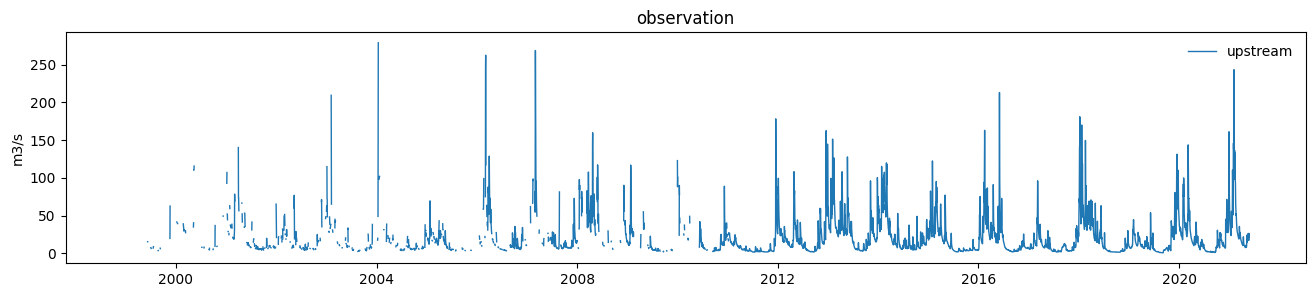

In [24]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(
    streamflow_ds,
    lw=1,
    label='upstream'
)
# ax.plot(
#     streamflow.downstream,
#     lw=1,
#     ls='--',
#     label='downstream'
# )
ax.set(
    # xlim=(start, end),
    ylabel='m3/s',
    title='observation'
)
ax.legend(frameon=False);

### Simulated

In [9]:
sim_files = {
    'inflow': path_efas / 'tests' / 'RES_inflow.csv',
    'outflow': path_efas / 'tests' / 'RES_outflow.csv',
    'storage': path_efas / 'tests' / 'RES_fill.csv'
}

In [10]:
efas6 = pd.DataFrame(dtype=float)
for var, file in sim_files.items():
    # load simulated time series
    data = pd.read_csv(
        file, 
        parse_dates=True, 
        index_col=0
    )
    data.columns = data.columns.astype(int)
    data.index = pd.to_datetime(data.index, format='%d/%m/%Y %H:%M')

    if gdw_id in data.columns:
        serie = data[gdw_id]
        if var == 'storage':
            serie *= cap_cm #reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
        efas6[var] = serie
    else:
        print(f'{gdw_id} was not found in the {var} simulated time series')        

In [11]:
# resample daily
efas6_d = efas6.groupby(efas6.index.floor('D')).mean()

<Axes: xlabel='Timestamp'>

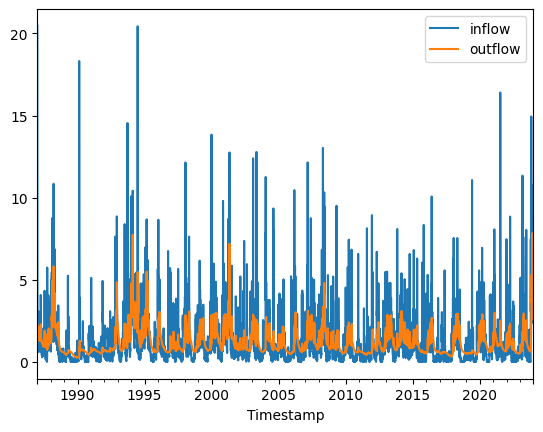

In [12]:
efas6_d[['inflow', 'outflow']].plot()

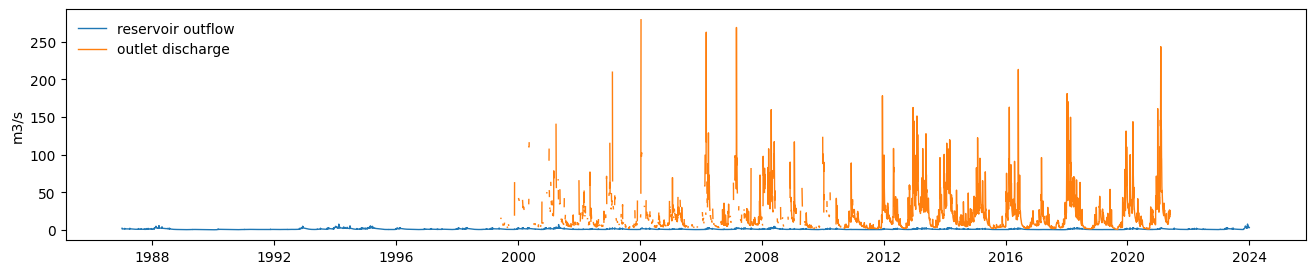

In [27]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    efas6_d.outflow,
    lw=1,
    ls='-',
    label='reservoir outflow'
)
ax.plot(
    streamflow_ds,
    lw=1,
    # ls='--',
    label='outlet discharge'
)
# kge = KGEmod(obs=streamflow.upstream, sim=efas6_d['inflow'])[0]
ax.set(
    # xlim=(start, end),
    ylabel='m3/s',
    # title=f'KGE = {kge:.3f}'
)

ax.legend(frameon=False);

## Analysis

In [14]:
path_results = path_catchment / '3184'
path_results.mkdir(parents=True, exist_ok=True)

### EFAS6 simulation

In [15]:
# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

In [16]:
# declare reservoir
res = Camaflood(
    Vmin=Vmin,
    Vf=Vf,
    Ve=Ve,
    Vtot=cap_cm,
    Qn=Qn,
    Qf=Qf,
    catchment=catch_sm,
    Atot=area_sm,
    timestep=6*3600
)

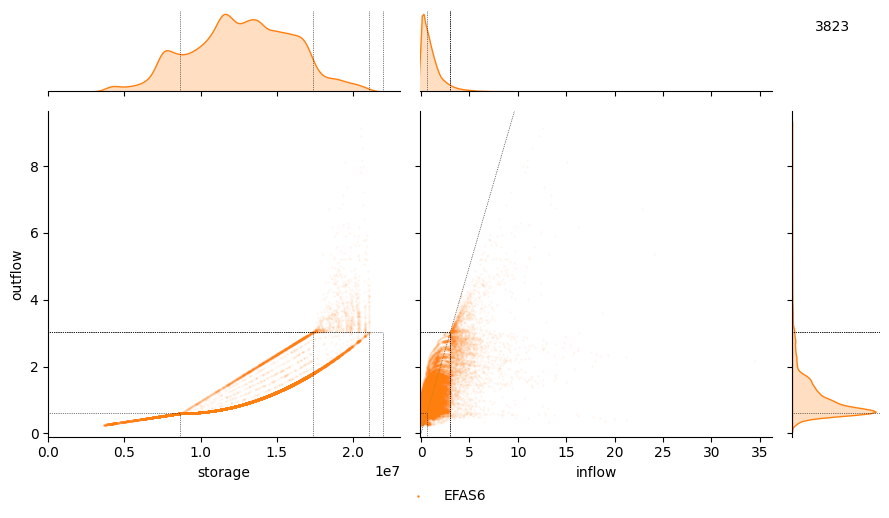

In [17]:
# compare LISFLOOD vs observation
res.scatter(
    efas6,
    obs=None,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6'],
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

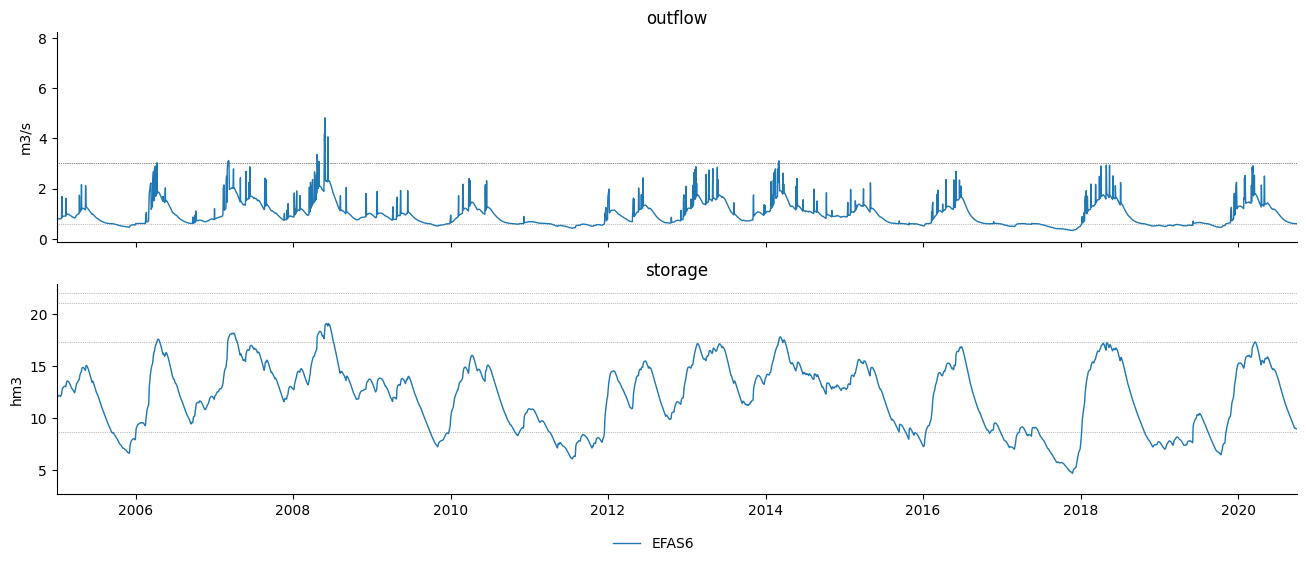

In [18]:
res.lineplot(
    sim={
        'EFAS6': efas6_d,
    },
    obs=None,
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=cfg.SPINUP,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
)

In [ ]:
efas6_d.index.min(), efas6_d.index.max()

In [ ]:
streamflow.index.min(), streamflow.index.max()

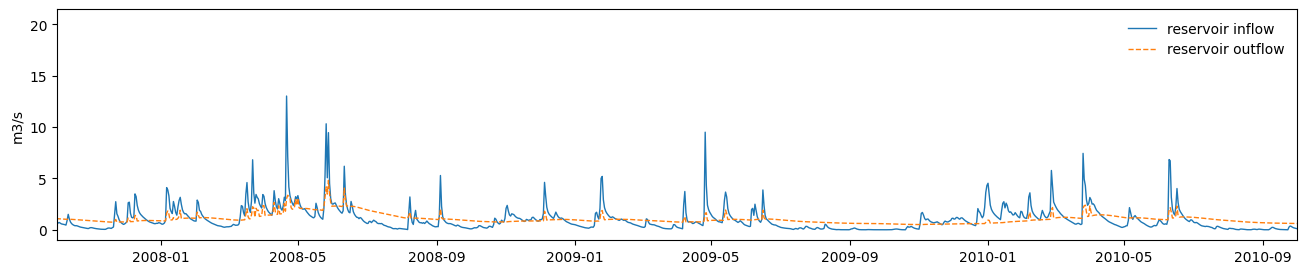

In [32]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    efas6_d.inflow,
    lw=1,
    ls='-',
    label='reservoir inflow'
)
ax.plot(
    efas6_d.outflow,
    lw=1,
    ls='--',
    label='reservoir outflow'
)
# kge, alpha, beta, r = KGEmod(obs=streamflow.upstream, sim=efas6_d.inflow)
ax.set(
    xlim=(datetime(2007, 10, 1), datetime(2010, 10, 1)),
    # ylim=(None, 600),
    ylabel='m3/s',
    # title=fr'KGE={kge:.2f}  $\alpha$={alpha:.3f}  $\beta$={beta:.3f}  $\rho$={r:.3f}'
)

ax.legend(frameon=False);

### Simulate CaMa-Flood

In [33]:
sim = res.simulate(
    inflow=efas6.inflow,
    Vo=None,
)

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

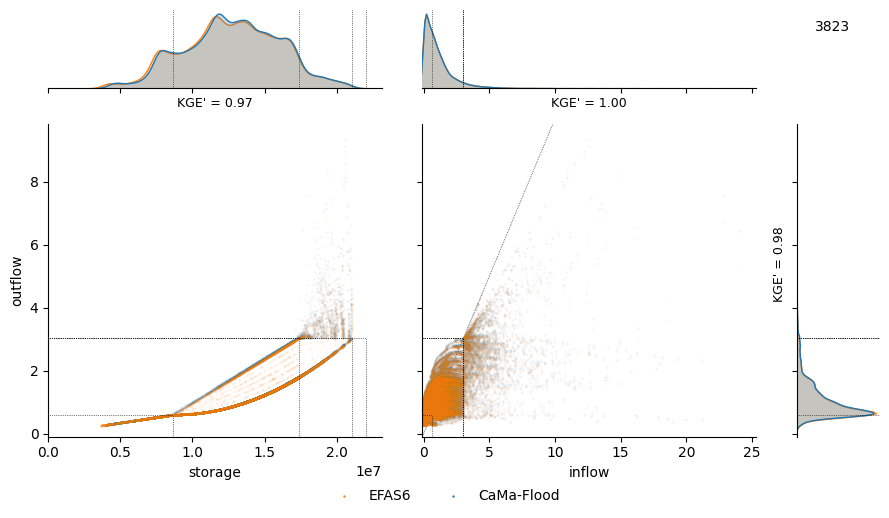

In [34]:
# compare EFAS6 vs CaMa-Flood
res.scatter(
    efas6,
    sim,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6', 'CaMa-Flood'],
    spinup=365,
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

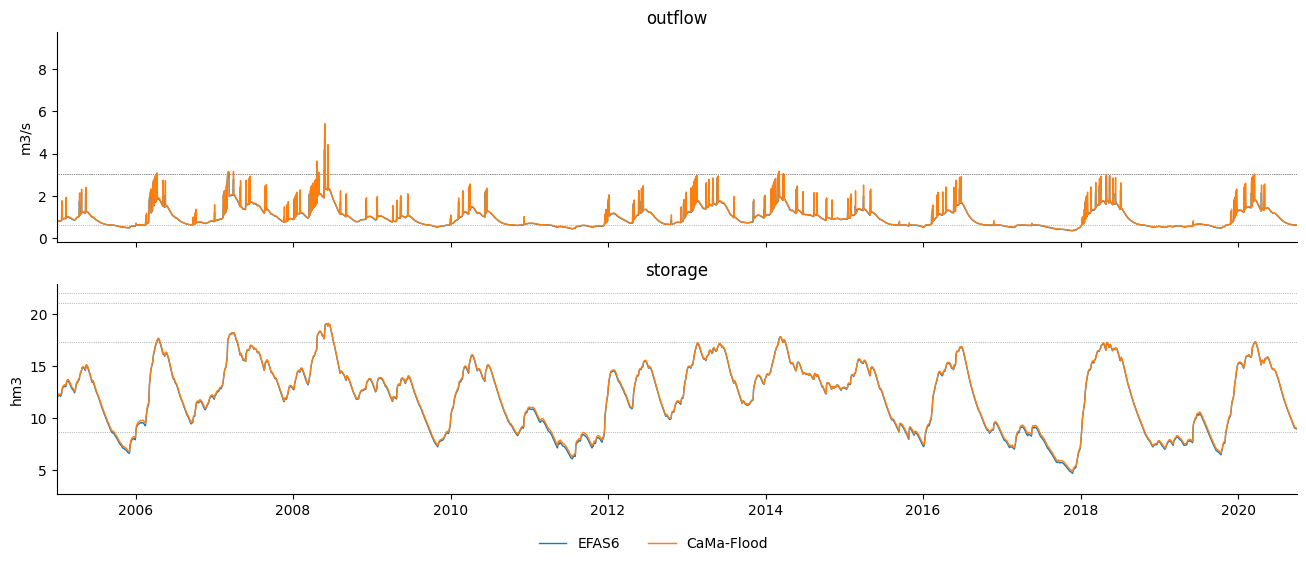

In [36]:
res.lineplot(
    sim={
        'EFAS6': efas6_d,
        'CaMa-Flood': sim,
    },
    obs=None,
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=365,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
)

The plots above prove that the CaMa-Flood routine in OS-LISFLOOD behaves as expected (as the isolated routine in `lisflood-reservoirs`) at 6-hour time steps.

### Calibrate CaMa-Flood

In [ ]:
parameters_cal = {
    'alpha': {
        'low': 0.2,
        'high': 0.99
    },
    'delta': {
        'low': 0.1,
        'high': 0.5
    },
}

target = ['storage', 'outflow']

In [ ]:
# time series: simulated inflow, observed storage and outflow
cal_ts = pd.concat([efas6_d.inflow, hydro.storage, hydro.outflow], axis=1)
mask = cal_ts.notnull().all(axis=1)
start, end = cal_ts[mask].index[0], cal_ts[mask].index[-1]
cal_ts = cal_ts.loc[start:end]

In [ ]:
# declare reservoir
calibrator = CamafloodCalibrator(
    parameters=parameters_cal,
    inflow=cal_ts.inflow,
    storage=cal_ts.storage,
    outflow=cal_ts.outflow,
    Vmin=max(0, min(0.1 * cap_cm, cal_ts.storage.min())),
    Vtot=cap_cm,
    catchment=catch_sm,
    # Atot=area_sm,
    target=target,
    obj_func=KGEmod,
    spinup=365,
)

# define the sampling method
dbname = f'{path_results}/{gdw_id}_samples'
sceua = spotpy.algorithms.sceua(
    calibrator, 
    dbname=dbname, 
    dbformat='csv', 
    save_sim=False,
)

# launch calibration
sceua.sample(
    5000, 
    ngs=4, 
    kstop=5, 
    pcento=0.001, 
    peps=0.01
)

In [ ]:
# read calibration results
iterations, optimal_parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(optimal_parameters.values()))

# declare the reservoir with optimal parameters
res = get_model('camaflood', **calibrated_attrs)

In [ ]:
# simulate the reservoir
Vo = cal_ts.storage.iloc[0]
sim_cal = res.simulate(
    inflow=cal_ts.inflow,
    Vo=None if pd.isna(Vo) else Vo,
)

In [ ]:
reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

In [ ]:
optimal_parameters

In [ ]:
# define reservoir limits
Vf = optimal_parameters['alpha'] * cap_cm
Ve = cap_cm * (0.8 + 0.2 * optimal_parameters['delta'])
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

In [ ]:
res.scatter(
    sim_cal.iloc[365:],
    cal_ts.iloc[365:],
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['CaMa-Flood calib.', 'observed'],
    # save=path_results / f'{gdw_id}_scatter_CaMa-Flood_vs_observed.jpg'
)

In [ ]:
res.lineplot(
    sim={
        'EFAS6': efas6_d.iloc[365:],
        'CaMa-Flood calib.': sim_cal.iloc[365:],
    },
    obs=hydro.iloc[365:],
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=cfg.SPINUP,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_CaMa-Flood_vs_observed.jpg'
)

Calibrating the reservoir parameters given the inflow from EFAS6 can only improve the performance very slightly (0.02 in terms of both outflow and storage).

## Conclusion